# <font style="color:blue">Project 3: Kaggle Competition - Semantic Segmentation</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>1.1. Dataset Class</h3></td> <td><h3>7</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>1.2. Visualize dataset</h3></td> <td><h3>3</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>2. Evaluation Metrics</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>3. Model</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>4.1. Train</h3></td> <td><h3>7</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>4.2. Inference</h3></td> <td><h3>3</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>5. Prepare Submission CSV</h3></td><td><h3>10</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>6. Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>

---

**In this project, you have participated in the Kaggle competition, and also submit the notebook and othe code in the course lab.**

**This Kaggle competition is a semantic segmentation challenge.**

<h2>Dataset Description </h2>
<p>The dataset consists of 3,269 images in 12 classes (including background). All images were taken from drones in a variety of scales. Samples are shown below:
<img src="https://www.dropbox.com/scl/fi/pswwraz1cc9srd9d4hxm3/data_montage.jpg?rlkey=074v9mc32et70ijl0dz3y0rvs&dl=1" width="800" height="800">
<p>The data was splitted into public train set and private test set which is used for evaluation of submissions. You can split public subset into train and validation sets yourself.
Images are named with a unique <code>ImageId</code>. </p>
<p> You should segment and classify the images in the test set.</p>
<p>The dataset consists of landscape images taken from drones in a variety of scales.</p>

**The notebook is divided into sections. You have to write code, as mention in the section.  For other helper functions, you can write `.py` files and import them in the notebook. You have to submit the notebook along with `.py` files. Your submitted code must be runnable without any bug.**

# <font style="color:green">1. Data Exploration</font>

In this section, you have to write your custom dataset class and visualize a few images (max five images) and its mask.

## <font style="color:green">1.1. Dataset Class [7 Points]</font>

**In this sub-section, write your custom dataset class.**


**Note that there are not separate validation data, so you will have to create your validation set by dividing train data into train and validation data. Usually, in practice, we do `80:20` ratio for train and validation, respectively.** 

**for example:**

```
class SemSegDataset(Dataset):
    """ Generic Dataset class for semantic segmentation datasets.

        Arguments:
            data_path (string): Path to the dataset folder.
            images_folder (string): Name of the folder containing the images (related to the data_path).
            masks_folder (string): Name of the folder containing the masks (related to the data_path).
            csv_path (string): train or test csv file name
            image_ids (list): List of images.
            train_val_test (string): 'train', 'val' or 'test'
            transforms (callable, optional): A function/transform that inputs a sample
                and returns its transformed version.
            class_names (list, optional): Names of the classes.
            

        Dataset folder structure:
            Folder containing the dataset should look like:
            - data_path
            -- images_folder
            -- masks_folder

            Names of images in the images_folder and masks_folder should be the same for same samples.
    """
```

In [1]:
import zipfile
import tarfile
from pathlib import Path

# Set your dataset path and extraction directory
dataset_path = "opencv-pytorch-segmentation-project-round2.zip"   # change this to your file name (e.g., .zip or .tar.gz)
extract_to = "data"  # folder to extract contents into

# Create extraction directory if it doesn't exist
Path(extract_to).mkdir(parents=True, exist_ok=True)

# --- For ZIP files ---
if dataset_path.endswith(".zip"):
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"✅ Extracted {dataset_path} into {extract_to}")


✅ Extracted opencv-pytorch-segmentation-project-round2.zip into data


In [1]:
!pip install albumentations

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install segmentation-models-pytorch

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# ========================
# 1. Imports
# ========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
# ========================
# 2. Constants & Paths
# ========================
DATA_PATH = '/home/aikarimi/PJ03/data/'
IMAGES_FOLDER = 'imgs/imgs'
MASKS_FOLDER = 'masks/masks'
TRAIN_CSV = os.path.join(DATA_PATH, 'train.csv')
TEST_CSV = os.path.join(DATA_PATH, 'test.csv')
SAMPLE_SUBMISSION = os.path.join(DATA_PATH, 'sampleSubmission.csv')

# Class names (12 classes including background)
CLASS_NAMES = [
    'background', 'building', 'road', 'water', 'barren', 'forest',
    'agriculture', 'brushland', 'baseball_diamond', 'basketball_court',
    'football_field', 'tennis_court'
]

# Target image size (as per competition note: resize to 512x384 before RLE)
TARGET_SIZE = (384, 512)  # (H, W)

In [6]:
class SemSegDataset(Dataset):
    """ Generic Dataset class for semantic segmentation datasets.
    Arguments:
        data_path(string): Path to the dataset folder.
        images_folder(string): Name of the folder containing the images(related to the data_path).
        masks_folder(string): Name of the folder containing the masks(related to the data_path).
        csv_path(string): train or test csv file name
        image_ids(list): List of images.
        train_val_test(string): 'train','val' or'test'
        transforms(callable, optional): A function/transform that inputs a sample and returns its transformed version.
        class_names(list, optional): Names of the classes.
    """
    def __init__(self, data_path, images_folder, masks_folder, csv_path, image_ids, train_val_test='train',
                 transforms=None, class_names=None):
        self.data_path = data_path
        self.images_folder = os.path.join(data_path, images_folder)
        self.masks_folder = os.path.join(data_path, masks_folder)
        self.image_ids = image_ids
        self.train_val_test = train_val_test
        self.csv_path = csv_path
        self.transforms = transforms
        self.class_names = class_names

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.images_folder, f"{img_id}.jpg")
        mask_path = os.path.join(self.masks_folder, f"{img_id}.png")
    
        # Load image
        image = np.array(Image.open(img_path).convert("RGB"))
        # Load mask
        mask = np.array(Image.open(mask_path))  # This is uint8
    
        # Apply transforms
        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']  # Already tensor from ToTensorV2
            mask = augmented['mask']    # Also tensor, but may be uint8
    
        # Ensure mask is long (int64) for CrossEntropyLoss
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).long()
        else:
            mask = mask.long()  # Convert to long if already tensor
    
        return image, mask

## <font style="color:green">1.2. Visualize dataset [3 Points]</font>

**In this sub-section,  you have to plot a few images and its mask.**

**for example:**

---

<img src="https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-data-sample.png">

---

In [7]:
def denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Denormalize an image tensor.
    Args:
        image: Tensor of shape (C, H, W) or numpy array.
        mean, std: Normalization parameters used during training.
    Returns:
        Denormalized image as numpy array in [0, 1] range.
    """
    if isinstance(image, torch.Tensor):
        image = image.clone().cpu().numpy()

    # Reverse normalization
    image = image * np.array(std)[:, None, None] + np.array(mean)[:, None, None]
    image = np.clip(image, 0, 1)  # Ensure values are in [0, 1]
    return image

In [8]:
def visualize_dataset(dataset, num_samples=5):
    # Create a copy of the dataset with visualization transform
    vis_dataset = SemSegDataset(
        data_path=dataset.data_path,
        images_folder=dataset.images_folder,
        masks_folder=dataset.masks_folder,
        csv_path=dataset.csv_path,
        image_ids=dataset.image_ids[:num_samples],  # Only first num_samples
        train_val_test=dataset.train_val_test,
        transforms=vis_transform,  # Use clean transform
        class_names=dataset.class_names
    )

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))
    for i in range(num_samples):
        img, mask = vis_dataset[i]
        # Denormalize for visualization
        img_vis = denormalize(img)
        img_vis = img_vis.transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

        mask = mask.numpy()

        axes[i, 0].imshow(img_vis)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='tab20', vmin=0, vmax=11)
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

Visualizing 5 samples from training set:


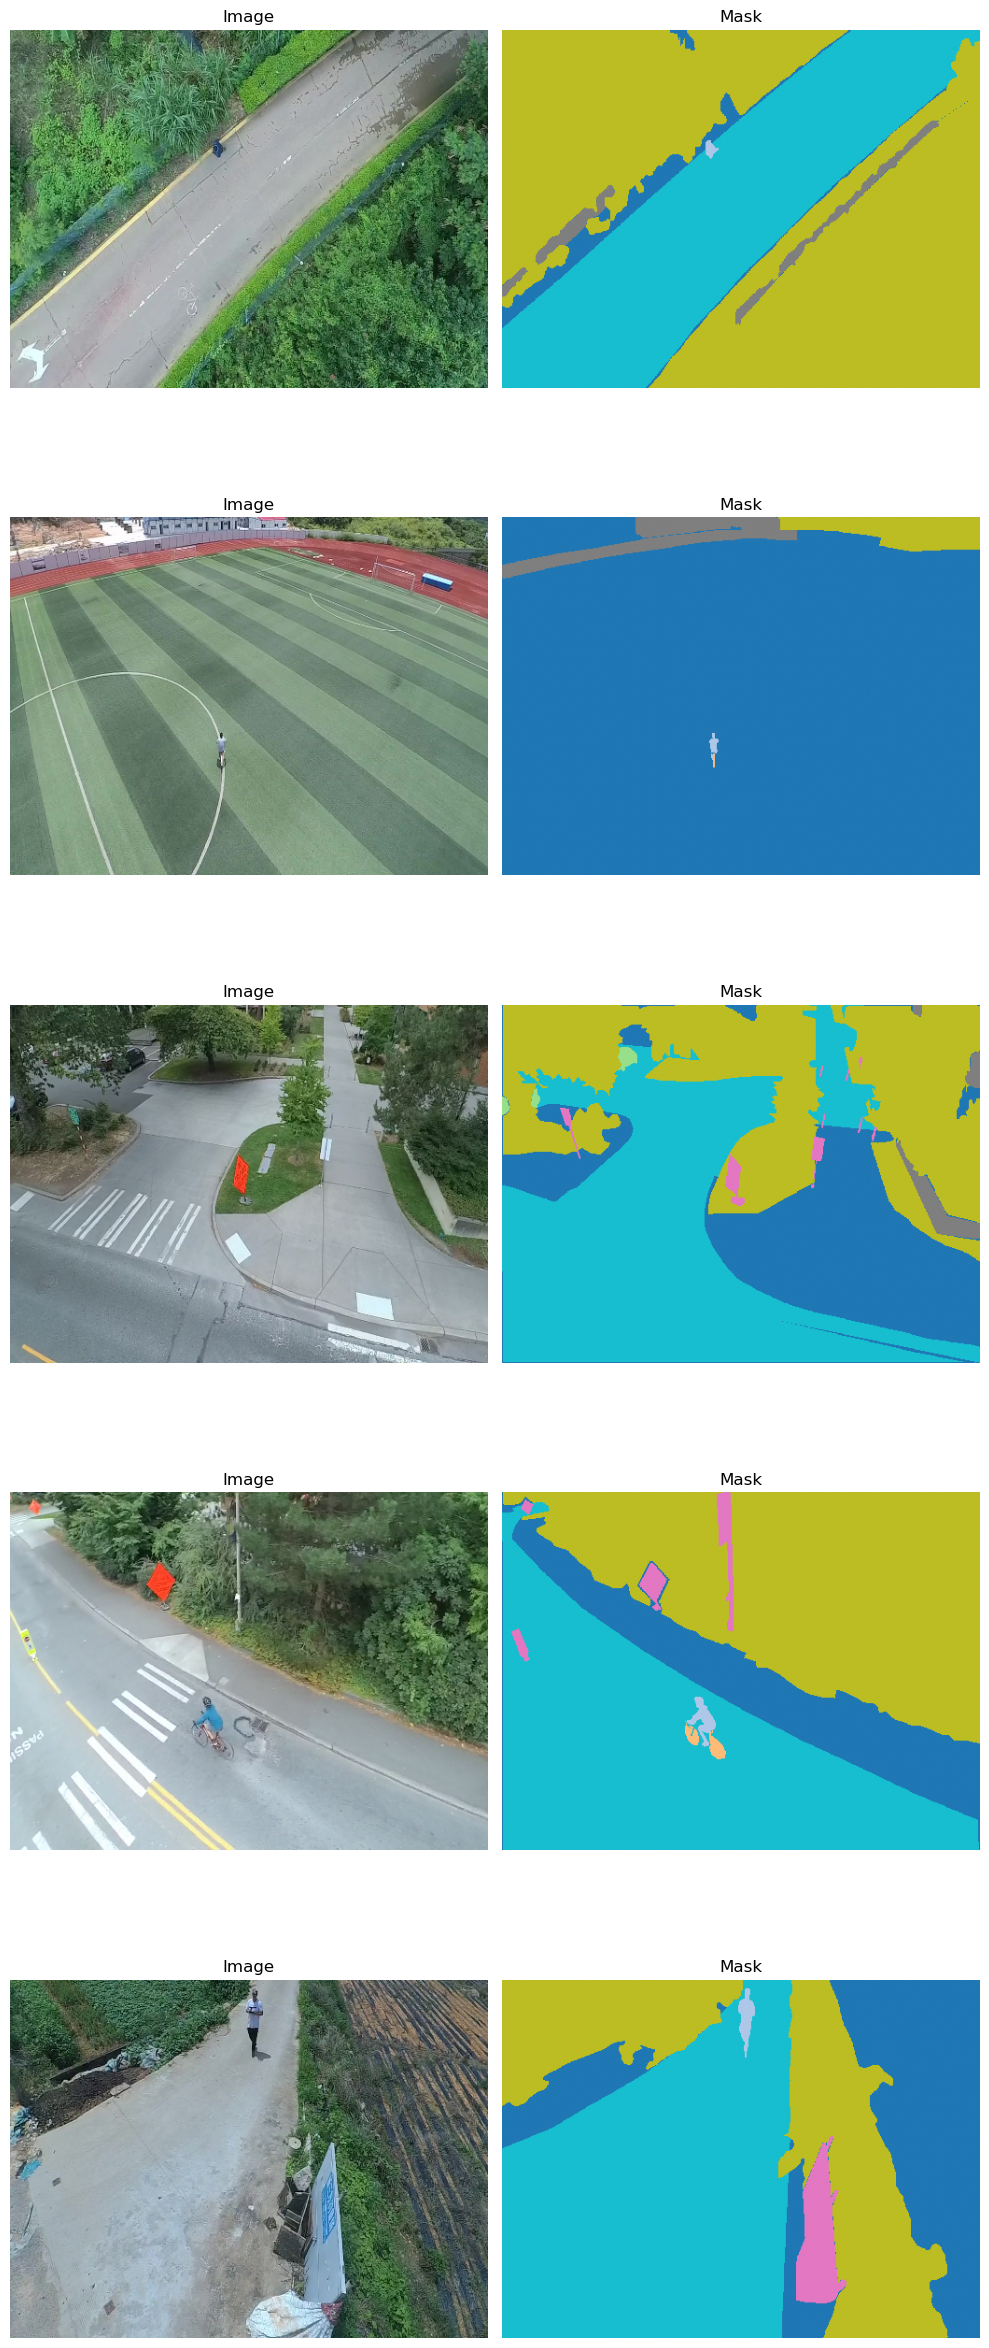

In [9]:

# Load train CSV
train_df = pd.read_csv(TRAIN_CSV)
all_image_ids = train_df['ImageID'].tolist()

# Calculate background ratio for each image
background_ratios = []
for img_id in all_image_ids:
    mask_path = os.path.join(DATA_PATH, MASKS_FOLDER, f"{img_id}.png")
    mask = np.array(Image.open(mask_path))
    bg_ratio = (mask == 0).sum() / mask.size
    background_ratios.append(bg_ratio)

# Stratify split by background ratio
train_ids, val_ids = train_test_split(
    all_image_ids,
    test_size=0.2,
    stratify=pd.qcut(background_ratios, 5, duplicates='drop'),  # 5 bins
    random_state=42
)

# Define transforms
train_transform = A.Compose([
    A.Resize(height=TARGET_SIZE[0], width=TARGET_SIZE[1]),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.2),  # Simulates occlusions
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=TARGET_SIZE[0], width=TARGET_SIZE[1]),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Transform for visualization (no random augmentations)
vis_transform = A.Compose([
    A.Resize(height=TARGET_SIZE[0], width=TARGET_SIZE[1]),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Create datasets
train_dataset = SemSegDataset(
    data_path=DATA_PATH,
    images_folder=IMAGES_FOLDER,
    masks_folder=MASKS_FOLDER,
    csv_path=TRAIN_CSV,
    image_ids=train_ids,
    train_val_test='train',
    transforms=train_transform,
    class_names=CLASS_NAMES
)

val_dataset = SemSegDataset(
    data_path=DATA_PATH,
    images_folder=IMAGES_FOLDER,
    masks_folder=MASKS_FOLDER,
    csv_path=TRAIN_CSV,
    image_ids=val_ids,
    train_val_test='val',
    transforms=val_transform,
    class_names=CLASS_NAMES
)



# Visualize
print("Visualizing 5 samples from training set:")
visualize_dataset(train_dataset, 5)

In [10]:
# Define DataLoaders
BATCH_SIZE = 8  # You can increase to 16 if you have enough GPU memory
NUM_WORKERS = 2  # Adjust based on your system

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True  # Speeds up data transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

In [11]:
print("Train loader length:", len(train_loader))
print("Val loader length:", len(val_loader))

# Test one batch
for images, masks in train_loader:
    print("Batch shape:", images.shape)  # Should be [B, 3, H, W]
    print("Mask shape:", masks.shape)    # Should be [B, H, W]
    break

Train loader length: 262
Val loader length: 66
Batch shape: torch.Size([8, 3, 384, 512])
Mask shape: torch.Size([8, 384, 512])


# <font style="color:green">2. Evaluation Metrics [10 Points]</font>

<p>This competition is evaluated on the mean <a href='https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient'>Dice coefficient</a
>. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by: </p>

<p>$$DSC =  \frac{2 |X \cap Y|}{|X|+ |Y|}$$
$$ \small \mathrm{where}\ X = Predicted\ Set\ of\ Pixels,\ \ Y = Ground\ Truth $$ </p>
<p>The Dice coefficient is defined to be 1 when both X and Y are empty.</p>

**In this section, you have to implement the dice coefficient evaluation metric.**

In [12]:
# ========================
# 2. Evaluation Metrics
# ========================
def dice_coefficient(y_pred, y_true, eps=1e-7):
    """
    Compute Dice coefficient for one class.
    y_pred: predicted mask (binary, shape [H, W])
    y_true: ground truth mask (binary, shape [H, W])
    """
    intersection = (y_pred * y_true).sum()
    union = y_pred.sum() + y_true.sum()
    dice = (2. * intersection + eps) / (union + eps)
    return dice

def mean_dice_batch(y_pred, y_true, num_classes=12, eps=1e-7):
    """
    Compute mean Dice coefficient over all classes for a batch.
    y_pred: predicted mask (shape [B, H, W]) with class labels
    y_true: ground truth mask (shape [B, H, W]) with class labels
    """
    dice_scores = []
    for cls in range(num_classes):
        pred_cls = (y_pred == cls).float()
        true_cls = (y_true == cls).float()
        intersection = (pred_cls * true_cls).sum(dim=(1,2))  # Sum over H, W
        union = pred_cls.sum(dim=(1,2)) + true_cls.sum(dim=(1,2))
        dice = (2. * intersection + eps) / (union + eps)
        dice_scores.append(dice.mean().item())  # Mean over batch
    return np.mean(dice_scores)

def mean_dice_coefficient(y_pred, y_true, num_classes=12, eps=1e-7):
    """
    Compute mean Dice coefficient over all classes.
    y_pred: predicted mask (shape [H, W]) with class labels
    y_true: ground truth mask (shape [H, W]) with class labels
    """
    dice_scores = []
    for cls in range(num_classes):
        pred_cls = (y_pred == cls).float()
        true_cls = (y_true == cls).float()
        dice = dice_coefficient(pred_cls, true_cls, eps)
        dice_scores.append(dice)
    return np.mean(dice_scores)

def compute_iou_per_class(y_pred, y_true, num_classes=12):
    """
    Compute IoU for each class.
    y_pred: predicted mask (shape [H, W]) with class labels (numpy array)
    y_true: ground truth mask (shape [H, W]) with class labels (numpy array)
    """
    iou_scores = []
    for cls in range(num_classes):
        pred_cls = (y_pred == cls).astype(np.float32)   # ← Use .astype(np.float32)
        true_cls = (y_true == cls).astype(np.float32)   # ← Same here
        intersection = (pred_cls * true_cls).sum()
        union = (pred_cls + true_cls - pred_cls * true_cls).sum()
        if union == 0:
            iou = 1.0
        else:
            iou = intersection / union
        iou_scores.append(iou)
    return iou_scores

# <font style="color:green">3. Model [10 Points]</font>

**In this section, you have to define your model.**

In [13]:
# Calculate class weights from train set
class_counts = np.zeros(12)
for img_id in train_ids:
    mask_path = os.path.join(DATA_PATH, MASKS_FOLDER, f"{img_id}.png")
    mask = np.array(Image.open(mask_path))
    unique, counts = np.unique(mask, return_counts=True)
    for cls, cnt in zip(unique, counts):
        if cls < 12:
            class_counts[cls] += cnt

class_weights = 1.0 / (class_counts + 1e-6)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [14]:
import torch.nn.functional as F
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        # pred: [B, C, H, W], target: [B, H, W]
        pred = torch.softmax(pred, dim=1)  # Convert logits to probabilities
        target = F.one_hot(target, num_classes=12).permute(0, 3, 1, 2).float()  # One-hot encode

        intersection = (pred * target).sum(dim=(2, 3))  # Sum over H, W
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)

        return 1 - dice.mean()  # Return 1 - mean Dice (so we minimize it)

# Combine with CrossEntropyLoss
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.ce_loss = nn.CrossEntropyLoss()
        self.dice_loss = DiceLoss()

    def forward(self, pred, target):
        ce = self.ce_loss(pred, target)
        dice = self.dice_loss(pred, target)
        return self.alpha * ce + self.beta * dice

In [15]:
# ========================
# 3. Model
# ========================
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=12,
    activation=None
).to(device)


criterion = CombinedLoss(alpha=0.5, beta=0.5)  # You can tune these weights
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=50,
    pct_start=0.3,
    div_factor=10,
    final_div_factor=100
)

# <font style="color:green">4. Train & Inference</font>

- **In this section, you have to train the model and infer on sample data.**


- **You can write your trainer class in this section.**


- **If you are using any loss function other than PyTorch standard loss function, you have to define in this section.**


- **This section should also have optimizer and LR-schedular (if using) details.**



## <font style="color:green">4.1. Train [7 Points]</font>

**Write your training code in this sub-section.**


**This section must contain training plots (use matplotlib or share tensorboard.dev scalars logs).**

**You must have to plot the following:**
- **train loss**


- **validation loss**


- **IoU for all twelve classes (0-11) and the mean IoU of all classes on validatin data.** 

**an example of matplotlib plot:**

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-train-loss.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-val-loss.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-mean_iou.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-iou-0.png'>

---

<center>*</center>
<center>*</center>
<center>*</center>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-iou-11.png'>

---


Epoch 1/70


Training: 100%|██████████| 262/262 [00:35<00:00,  7.29it/s]


Train Loss: 0.9988


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.80it/s]


Val Loss: 0.6918, Mean Dice: 0.6345
Epoch 2/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.28it/s]


Train Loss: 0.6344


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.54it/s]


Val Loss: 0.5526, Mean Dice: 0.6500
Epoch 3/70


Training: 100%|██████████| 262/262 [00:27<00:00,  9.42it/s]


Train Loss: 0.5558


Validation: 100%|██████████| 66/66 [00:16<00:00,  3.93it/s]


Val Loss: 0.5214, Mean Dice: 0.6416
Epoch 4/70


Training: 100%|██████████| 262/262 [00:27<00:00,  9.39it/s]


Train Loss: 0.5109


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.62it/s]


Val Loss: 0.4983, Mean Dice: 0.6670
Epoch 5/70


Training: 100%|██████████| 262/262 [00:29<00:00,  8.99it/s]


Train Loss: 0.4916


Validation: 100%|██████████| 66/66 [00:17<00:00,  3.80it/s]


Val Loss: 0.4695, Mean Dice: 0.7270
Epoch 6/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.34it/s]


Train Loss: 0.4673


Validation: 100%|██████████| 66/66 [00:19<00:00,  3.46it/s]


Val Loss: 0.4524, Mean Dice: 0.7118
Epoch 7/70


Training: 100%|██████████| 262/262 [00:29<00:00,  8.83it/s]


Train Loss: 0.4449


Validation: 100%|██████████| 66/66 [00:17<00:00,  3.87it/s]


Val Loss: 0.4447, Mean Dice: 0.7303
Epoch 8/70


Training: 100%|██████████| 262/262 [00:29<00:00,  8.86it/s]


Train Loss: 0.4429


Validation: 100%|██████████| 66/66 [00:15<00:00,  4.21it/s]


Val Loss: 0.4532, Mean Dice: 0.6910
Epoch 9/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.32it/s]


Train Loss: 0.4329


Validation: 100%|██████████| 66/66 [00:15<00:00,  4.20it/s]


Val Loss: 0.4209, Mean Dice: 0.7452
Epoch 10/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.15it/s]


Train Loss: 0.4136


Validation: 100%|██████████| 66/66 [00:12<00:00,  5.24it/s]


Val Loss: 0.4084, Mean Dice: 0.7699
Epoch 11/70


Training: 100%|██████████| 262/262 [00:29<00:00,  9.01it/s]


Train Loss: 0.4066


Validation: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s]


Val Loss: 0.3992, Mean Dice: 0.7725
Epoch 12/70


Training: 100%|██████████| 262/262 [00:27<00:00,  9.52it/s]


Train Loss: 0.3962


Validation: 100%|██████████| 66/66 [00:12<00:00,  5.41it/s]


Val Loss: 0.3885, Mean Dice: 0.7900
Epoch 13/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.17it/s]


Train Loss: 0.3850


Validation: 100%|██████████| 66/66 [00:19<00:00,  3.30it/s]


Val Loss: 0.3845, Mean Dice: 0.8085
Epoch 14/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.09it/s]


Train Loss: 0.3831


Validation: 100%|██████████| 66/66 [00:24<00:00,  2.68it/s]


Val Loss: 0.3857, Mean Dice: 0.8063
Epoch 15/70


Training: 100%|██████████| 262/262 [00:27<00:00,  9.44it/s]


Train Loss: 0.3826


Validation: 100%|██████████| 66/66 [00:17<00:00,  3.87it/s]


Val Loss: 0.3828, Mean Dice: 0.8063
Epoch 16/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.05it/s]


Train Loss: 0.3826


Validation: 100%|██████████| 66/66 [00:21<00:00,  3.10it/s]


Val Loss: 0.3916, Mean Dice: 0.8075
Epoch 17/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.14it/s]


Train Loss: 0.3821


Validation: 100%|██████████| 66/66 [00:24<00:00,  2.70it/s]


Val Loss: 0.3766, Mean Dice: 0.8161
Epoch 18/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.20it/s]


Train Loss: 0.3720


Validation: 100%|██████████| 66/66 [00:20<00:00,  3.15it/s]


Val Loss: 0.3709, Mean Dice: 0.8178
Epoch 19/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.13it/s]


Train Loss: 0.3738


Validation: 100%|██████████| 66/66 [00:23<00:00,  2.83it/s]


Val Loss: 0.3728, Mean Dice: 0.8216
Epoch 20/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.20it/s]


Train Loss: 0.3662


Validation: 100%|██████████| 66/66 [00:12<00:00,  5.38it/s]


Val Loss: 0.3765, Mean Dice: 0.8329
Epoch 21/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.34it/s]


Train Loss: 0.3705


Validation: 100%|██████████| 66/66 [00:17<00:00,  3.82it/s]


Val Loss: 0.3674, Mean Dice: 0.8394
Epoch 22/70


Training: 100%|██████████| 262/262 [00:27<00:00,  9.41it/s]


Train Loss: 0.3695


Validation: 100%|██████████| 66/66 [00:14<00:00,  4.43it/s]


Val Loss: 0.3686, Mean Dice: 0.8244
Epoch 23/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.12it/s]


Train Loss: 0.3623


Validation: 100%|██████████| 66/66 [00:16<00:00,  3.98it/s]


Val Loss: 0.3627, Mean Dice: 0.8366
Epoch 24/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.09it/s]


Train Loss: 0.3655


Validation: 100%|██████████| 66/66 [00:12<00:00,  5.08it/s]


Val Loss: 0.3716, Mean Dice: 0.8334
Epoch 25/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.27it/s]


Train Loss: 0.3732


Validation: 100%|██████████| 66/66 [00:10<00:00,  6.21it/s]


Val Loss: 0.3670, Mean Dice: 0.8252
Epoch 26/70


Training: 100%|██████████| 262/262 [00:27<00:00,  9.55it/s]


Train Loss: 0.3567


Validation: 100%|██████████| 66/66 [00:19<00:00,  3.41it/s]


Val Loss: 0.3622, Mean Dice: 0.8430
Epoch 27/70


Training: 100%|██████████| 262/262 [00:27<00:00,  9.42it/s]


Train Loss: 0.3621


Validation: 100%|██████████| 66/66 [00:14<00:00,  4.41it/s]


Val Loss: 0.3627, Mean Dice: 0.8466
Epoch 28/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.25it/s]


Train Loss: 0.3531


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.96it/s]


Val Loss: 0.3596, Mean Dice: 0.8454
Epoch 29/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.32it/s]


Train Loss: 0.3516


Validation: 100%|██████████| 66/66 [00:19<00:00,  3.45it/s]


Val Loss: 0.3572, Mean Dice: 0.8380
Epoch 30/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.12it/s]


Train Loss: 0.3495


Validation: 100%|██████████| 66/66 [00:14<00:00,  4.42it/s]


Val Loss: 0.3600, Mean Dice: 0.8497
Epoch 31/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.22it/s]


Train Loss: 0.3501


Validation: 100%|██████████| 66/66 [00:15<00:00,  4.39it/s]


Val Loss: 0.3543, Mean Dice: 0.8527
Epoch 32/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.12it/s]


Train Loss: 0.3487


Validation: 100%|██████████| 66/66 [00:28<00:00,  2.33it/s]


Val Loss: 0.3535, Mean Dice: 0.8518
Epoch 33/70


Training: 100%|██████████| 262/262 [00:29<00:00,  8.94it/s]


Train Loss: 0.3451


Validation: 100%|██████████| 66/66 [00:19<00:00,  3.45it/s]


Val Loss: 0.3527, Mean Dice: 0.8610
Epoch 34/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.09it/s]


Train Loss: 0.3473


Validation: 100%|██████████| 66/66 [00:14<00:00,  4.45it/s]


Val Loss: 0.3544, Mean Dice: 0.8566
Epoch 35/70


Training: 100%|██████████| 262/262 [00:27<00:00,  9.42it/s]


Train Loss: 0.3463


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.89it/s]


Val Loss: 0.3552, Mean Dice: 0.8448
Epoch 36/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.17it/s]


Train Loss: 0.3452


Validation: 100%|██████████| 66/66 [00:16<00:00,  3.97it/s]


Val Loss: 0.3517, Mean Dice: 0.8545
Epoch 37/70


Training: 100%|██████████| 262/262 [00:27<00:00,  9.44it/s]


Train Loss: 0.3591


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.54it/s]


Val Loss: 0.3629, Mean Dice: 0.8328
Epoch 38/70


Training: 100%|██████████| 262/262 [00:27<00:00,  9.37it/s]


Train Loss: 0.3577


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.53it/s]


Val Loss: 0.3596, Mean Dice: 0.8520
Epoch 39/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.17it/s]


Train Loss: 0.3468


Validation: 100%|██████████| 66/66 [00:17<00:00,  3.71it/s]


Val Loss: 0.3528, Mean Dice: 0.8620
Epoch 40/70


Training: 100%|██████████| 262/262 [00:27<00:00,  9.52it/s]


Train Loss: 0.3420


Validation: 100%|██████████| 66/66 [00:15<00:00,  4.37it/s]


Val Loss: 0.3494, Mean Dice: 0.8637
Epoch 41/70


Training: 100%|██████████| 262/262 [00:29<00:00,  8.96it/s]


Train Loss: 0.3407


Validation: 100%|██████████| 66/66 [00:15<00:00,  4.27it/s]


Val Loss: 0.3485, Mean Dice: 0.8675
Epoch 42/70


Training: 100%|██████████| 262/262 [00:26<00:00,  9.71it/s]


Train Loss: 0.3392


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.54it/s]


Val Loss: 0.3479, Mean Dice: 0.8702
Epoch 43/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.06it/s]


Train Loss: 0.3430


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.49it/s]


Val Loss: 0.3522, Mean Dice: 0.8598
Epoch 44/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.14it/s]


Train Loss: 0.3532


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.97it/s]


Val Loss: 0.3637, Mean Dice: 0.8333
Epoch 45/70


Training: 100%|██████████| 262/262 [00:29<00:00,  8.97it/s]


Train Loss: 0.3487


Validation: 100%|██████████| 66/66 [00:19<00:00,  3.33it/s]


Val Loss: 0.3486, Mean Dice: 0.8624
Epoch 46/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.20it/s]


Train Loss: 0.3389


Validation: 100%|██████████| 66/66 [00:14<00:00,  4.53it/s]


Val Loss: 0.3459, Mean Dice: 0.8709
Epoch 47/70


Training: 100%|██████████| 262/262 [00:29<00:00,  8.88it/s]


Train Loss: 0.3373


Validation: 100%|██████████| 66/66 [00:12<00:00,  5.12it/s]


Val Loss: 0.3493, Mean Dice: 0.8722
Epoch 48/70


Training: 100%|██████████| 262/262 [00:27<00:00,  9.43it/s]


Train Loss: 0.3381


Validation: 100%|██████████| 66/66 [00:23<00:00,  2.87it/s]


Val Loss: 0.3434, Mean Dice: 0.8755
Epoch 49/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.22it/s]


Train Loss: 0.3373


Validation: 100%|██████████| 66/66 [00:20<00:00,  3.26it/s]


Val Loss: 0.3446, Mean Dice: 0.8839
Epoch 50/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.10it/s]


Train Loss: 0.3377


Validation: 100%|██████████| 66/66 [00:14<00:00,  4.60it/s]


Val Loss: 0.3447, Mean Dice: 0.8794
Epoch 51/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.11it/s]


Train Loss: 0.3361


Validation: 100%|██████████| 66/66 [00:09<00:00,  7.30it/s]


Val Loss: 0.3437, Mean Dice: 0.8788
Epoch 52/70


Training: 100%|██████████| 262/262 [00:29<00:00,  9.01it/s]


Train Loss: 0.3353


Validation: 100%|██████████| 66/66 [00:19<00:00,  3.41it/s]


Val Loss: 0.3441, Mean Dice: 0.8793
Epoch 53/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.07it/s]


Train Loss: 0.3458


Validation: 100%|██████████| 66/66 [00:21<00:00,  3.01it/s]


Val Loss: 0.3532, Mean Dice: 0.8681
Epoch 54/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.22it/s]


Train Loss: 0.3383


Validation: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s]


Val Loss: 0.3502, Mean Dice: 0.8795
Epoch 55/70


Training: 100%|██████████| 262/262 [00:29<00:00,  8.86it/s]


Train Loss: 0.3360


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.78it/s]


Val Loss: 0.3473, Mean Dice: 0.8770
Epoch 56/70


Training: 100%|██████████| 262/262 [00:29<00:00,  8.92it/s]


Train Loss: 0.3329


Validation: 100%|██████████| 66/66 [00:15<00:00,  4.30it/s]


Val Loss: 0.3435, Mean Dice: 0.8789
Epoch 57/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.08it/s]


Train Loss: 0.3318


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.66it/s]


Val Loss: 0.3416, Mean Dice: 0.8805
Epoch 58/70


Training: 100%|██████████| 262/262 [00:30<00:00,  8.67it/s]


Train Loss: 0.3382


Validation: 100%|██████████| 66/66 [00:20<00:00,  3.24it/s]


Val Loss: 0.3518, Mean Dice: 0.8658
Epoch 59/70


Training: 100%|██████████| 262/262 [00:29<00:00,  8.99it/s]


Train Loss: 0.3359


Validation: 100%|██████████| 66/66 [00:16<00:00,  4.09it/s]


Val Loss: 0.3445, Mean Dice: 0.8840
Epoch 60/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.12it/s]


Train Loss: 0.3340


Validation: 100%|██████████| 66/66 [00:21<00:00,  3.07it/s]


Val Loss: 0.3434, Mean Dice: 0.8818
Epoch 61/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.20it/s]


Train Loss: 0.3325


Validation: 100%|██████████| 66/66 [00:17<00:00,  3.80it/s]


Val Loss: 0.3416, Mean Dice: 0.8858
Epoch 62/70


Training: 100%|██████████| 262/262 [00:29<00:00,  8.96it/s]


Train Loss: 0.3315


Validation: 100%|██████████| 66/66 [00:20<00:00,  3.22it/s]


Val Loss: 0.3434, Mean Dice: 0.8839
Epoch 63/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.20it/s]


Train Loss: 0.3299


Validation: 100%|██████████| 66/66 [00:22<00:00,  2.96it/s]


Val Loss: 0.3415, Mean Dice: 0.8918
Epoch 64/70


Training: 100%|██████████| 262/262 [00:29<00:00,  8.80it/s]


Train Loss: 0.3297


Validation: 100%|██████████| 66/66 [00:20<00:00,  3.28it/s]


Val Loss: 0.3426, Mean Dice: 0.8862
Epoch 65/70


Training: 100%|██████████| 262/262 [00:29<00:00,  8.99it/s]


Train Loss: 0.3331


Validation: 100%|██████████| 66/66 [00:09<00:00,  6.64it/s]


Val Loss: 0.3454, Mean Dice: 0.8706
Epoch 66/70


Training: 100%|██████████| 262/262 [00:29<00:00,  8.96it/s]


Train Loss: 0.3343


Validation: 100%|██████████| 66/66 [00:14<00:00,  4.44it/s]


Val Loss: 0.3421, Mean Dice: 0.8743
Epoch 67/70


Training: 100%|██████████| 262/262 [00:29<00:00,  9.02it/s]


Train Loss: 0.3312


Validation: 100%|██████████| 66/66 [00:21<00:00,  3.01it/s]


Val Loss: 0.3398, Mean Dice: 0.8853
Epoch 68/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.10it/s]


Train Loss: 0.3295


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.62it/s]


Val Loss: 0.3421, Mean Dice: 0.8870
Epoch 69/70


Training: 100%|██████████| 262/262 [00:28<00:00,  9.06it/s]


Train Loss: 0.3318


Validation: 100%|██████████| 66/66 [00:21<00:00,  3.14it/s]


Val Loss: 0.3416, Mean Dice: 0.8848
Epoch 70/70


Training: 100%|██████████| 262/262 [00:29<00:00,  8.90it/s]


Train Loss: 0.3304


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s]


Val Loss: 0.3410, Mean Dice: 0.8898


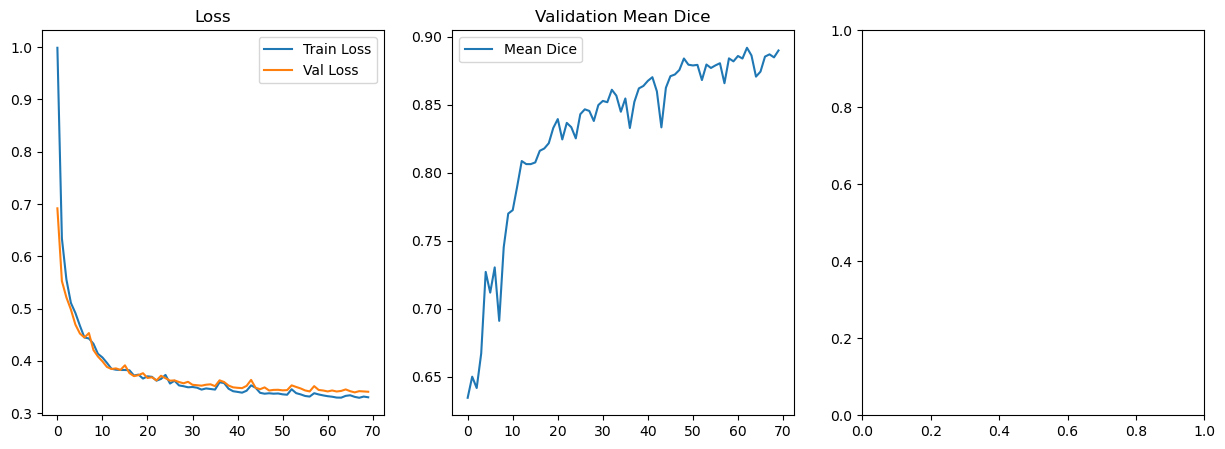

In [16]:
# ========================
# 4. Train & Inference
# ========================
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

# Training loop
num_epochs = 70  # Increase from 50
patience = 15    # Wait 15 epochs for improvement
train_losses = []
val_losses = []
val_mean_dices = []  # ← New list for Dice

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Training
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_loader, desc="Training"):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_running_loss = 0.0
    total_mean_dice = 0.0
    batch_dice_scores = []

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Validation"):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_running_loss += loss.item()

            # Get predicted classes
            preds = torch.argmax(outputs, dim=1).cpu()
            masks = masks.cpu()

            # Compute batch Dice
            batch_dice = mean_dice_batch(preds, masks, num_classes=12)
            batch_dice_scores.append(batch_dice)
            total_mean_dice += batch_dice

    avg_val_loss = val_running_loss / len(val_loader)
    mean_dice = total_mean_dice / len(val_loader)
    val_losses.append(avg_val_loss)
    val_mean_dices.append(mean_dice)
    best_val_dice=0
    if mean_dice > best_val_dice:
        best_val_dice = mean_dice
        torch.save(model.state_dict(), 'best_model.pth')
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping!")
            break
            
    print(f"Val Loss: {avg_val_loss:.4f}, Mean Dice: {mean_dice:.4f}")
    scheduler.step(mean_dice)

# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(val_mean_dices, label='Mean Dice')
plt.title('Validation Mean Dice')
plt.legend()

plt.subplot(1, 3, 3)
# Optional: Plot per-class Dice if needed
plt.show()

## <font style="color:green">4.2. Inference [3 Points]</font>

**Plot some sample inference in this sub-section.**

**for example:**

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-sample-predtiction.png'>

---



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134204].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


Visualizing inference on 3 validation samples:


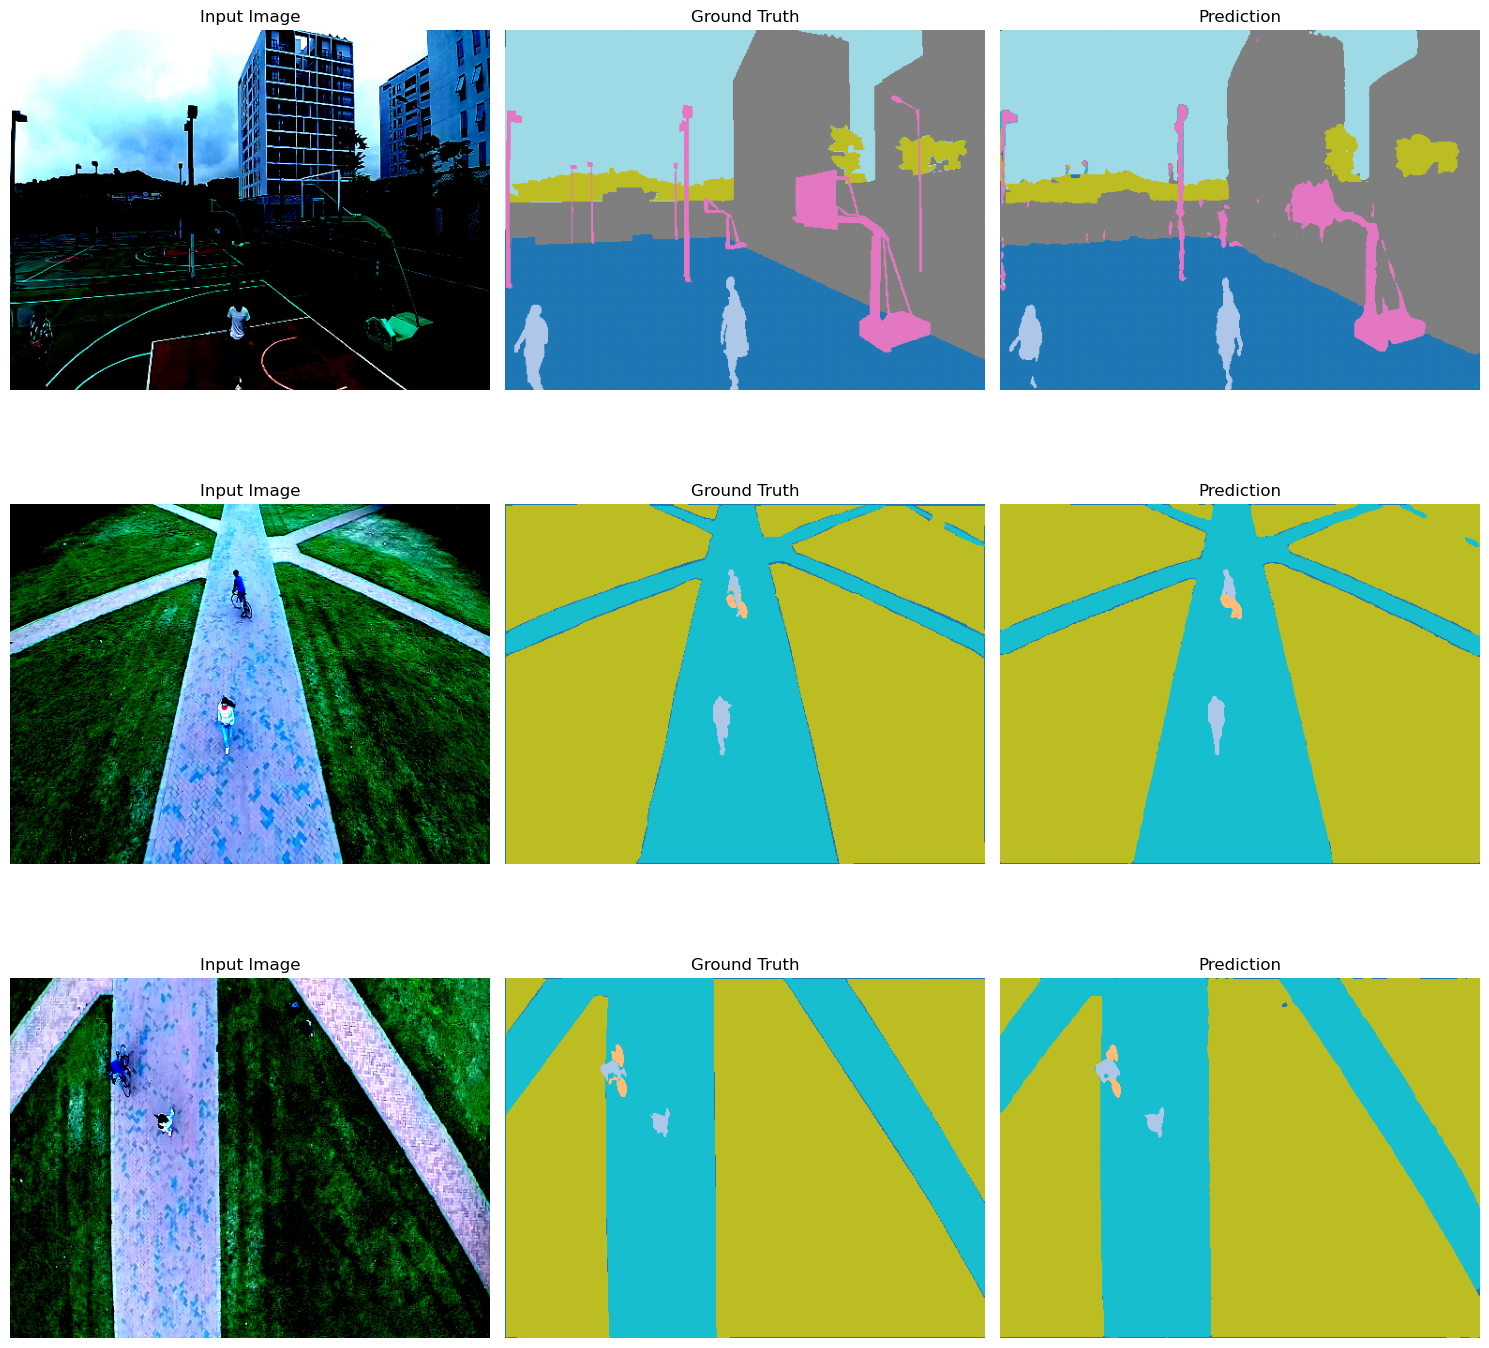

In [17]:
# ========================
# 4.2. Inference (Sample Visualization)
# ========================
def visualize_inference(model, dataset, num_samples=3):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    with torch.no_grad():
        for i in range(num_samples):
            img, mask = dataset[i]
            img_tensor = img.unsqueeze(0).to(device)
            output = model(img_tensor)
            pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

            img = img.permute(1, 2, 0).numpy()
            mask = mask.numpy()

            axes[i, 0].imshow(img)
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(mask, cmap='tab20', vmin=0, vmax=11)
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(pred_mask, cmap='tab20', vmin=0, vmax=11)
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

print("Visualizing inference on 3 validation samples:")
visualize_inference(model, val_dataset, 3)

# <font style="color:green">5. Prepare Submission CSV [10 Points]</font>

**Write your code to prepare the submission CSV file.**


**Note that in the submission file, you have to write Encoded Pixels.**

[Here is a blog to understand what is Encoded Pixels.](https://medium.com/analytics-vidhya/generating-masks-from-encoded-pixels-semantic-segmentation-18635e834ad0)

In [18]:
# ========================
# 5. Prepare Submission CSV
# ========================
def rle_encode(mask):
    """
    Run-Length Encode a binary mask.
    mask: 2D numpy array (H, W) of 0s and 1s.
    Returns: string of space-separated start lengths.
    """
    pixels = mask.flatten(order='F')  # Fortran order: top to bottom, left to right
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def generate_submission(model, test_csv_path, output_csv_path, target_size=(384, 512)):
    test_df = pd.read_csv(test_csv_path)
    image_ids = test_df['ImageID'].tolist()

    rows = []

    model.eval()
    with torch.no_grad():
        for img_id in tqdm(image_ids, desc="Generating Submission"):
            img_path = os.path.join(DATA_PATH, IMAGES_FOLDER, f"{img_id}.jpg")
            image = np.array(Image.open(img_path).convert("RGB"))
            # Resize to target size
            image = cv2.resize(image, (target_size[1], target_size[0]), interpolation=cv2.INTER_LINEAR)
            # Normalize
            image = image.astype(np.float32) / 255.0
            mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
            std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
            image = (image - mean) / std
            image = torch.from_numpy(image.transpose(2, 0, 1)).unsqueeze(0).to(device).to(torch.float32)

            output = model(image)
            pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

            # For each class, create binary mask and encode
            for cls in range(12):
                binary_mask = (pred_mask == cls).astype(np.uint8)
                encoded_pixels = rle_encode(binary_mask)
                rows.append({
                    'ImageID': f"{img_id}_{cls}",
                    'EncodedPixels': encoded_pixels
                })

    submission_df = pd.DataFrame(rows)
    submission_df.to_csv(output_csv_path, index=False)
    print(f"Submission saved to {output_csv_path}")

# Generate submission
SUBMISSION_CSV = os.path.join(DATA_PATH, 'submission.csv')
generate_submission(model, TEST_CSV, SUBMISSION_CSV, TARGET_SIZE)

# Verify submission format
sub_df = pd.read_csv(SUBMISSION_CSV)
print(f"Submission shape: {sub_df.shape}")
print(sub_df.head())

Generating Submission: 100%|██████████| 648/648 [00:14<00:00, 43.51it/s]


Submission saved to /home/aikarimi/PJ03/data/submission.csv
Submission shape: (7776, 2)
                 ImageID                                      EncodedPixels
0  9743172603816335085_0  383 2 32639 2 33023 2 33408 1 33792 1 52609 1 ...
1  9743172603816335085_1  95056 7 95437 11 95817 14 96198 16 96581 17 96...
2  9743172603816335085_2  96214 2 96570 3 96598 3 96946 18 96982 4 97330...
3  9743172603816335085_3                                                NaN
4  9743172603816335085_4                                                NaN


# <font style="color:green">6. Kaggle Profile Link [50 Points]</font>

Share your Kaggle profile link here with us so that we can give points for the competition score. 

You should have a minimum dice score of `0.60` on the test data to get all points. If the dice score is less than `0.55`, you will not get any points for the section. 

**You must have to submit `submission.csv` (prediction for images in `test.csv`) in `Submit Predictions` tab in Kaggle to get any evaluation in this section.**

In [ ]:
# ========================
# 6. Kaggle Profile Link
# ========================
# Students must submit their predictions on Kaggle and share their profile link.
# Example placeholder:
KAGGLE_PROFILE_LINK = "https://www.kaggle.com/yourusername"
print(f"Please submit your predictions on Kaggle and share your profile link here: {KAGGLE_PROFILE_LINK}")